In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import numpy as np

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras import backend as K, callbacks
import tensorflow as tf
import tensorflow.keras as keras

from sklearn.metrics import accuracy_score as accuracy, f1_score, mean_absolute_error as mae

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

sns.set_theme()

In [5]:
# Code for loading data and creating sequences

In [6]:
def load_data(file):
    df=pd.read_csv(file,index_col='Date')
    return df

def create_sequences(data, targets, seq_len = 60):
    sequences = []
    sequences_targets = []
    for i in range(len(data) - 60 + 1):
        seq_data = data[i:i+seq_len]
        seq_target = targets[i+60-1]

        sequences.append(seq_data)
        sequences_targets.append(seq_target)
    sequences = np.array(sequences)
    sequences = sequences.reshape(sequences.shape[0], sequences.shape[1], sequences.shape[2], 1)
    return np.array(sequences), np.array(sequences_targets)

def load_datasplits(index, seq_len = 60):
    seq_len = 60

    data = load_data(f'Dataset/{index}.csv')
    del data['Name']
    data = data.iloc[200:]
    data.fillna(0, inplace = True)

    targets = (data['Close'] < data['Close'].shift(-1)).astype(int)
    data = data[:-1]
    targets = targets[:-1]

    train_data = scale(data.loc[:'2016-04-20'])
    train_targets = targets.loc[:'2016-04-20']

    split = int(0.75*train_data.shape[0])

    val_data = train_data[split-60:]
    val_targets = train_targets[split-60:]

    train_data = train_data[:split]
    train_targets = train_targets[:split]

    test_data = scale(data.loc['2016-04-21':])
    test_targets = targets.loc['2016-04-21':]

    return train_data, train_targets, val_data, val_targets, test_data, test_targets

In [7]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_pos = precision(y_true, y_pred)
    recall_pos = recall(y_true, y_pred)
    precision_neg = precision((K.ones_like(y_true) - y_true), (K.ones_like(y_pred) - K.clip(y_pred, 0, 1)))
    recall_neg = recall((K.ones_like(y_true) - y_true), (K.ones_like(y_pred) - K.clip(y_pred, 0, 1)))
    f_posit = 2 * ((precision_pos * recall_pos) / (precision_pos + recall_pos + K.epsilon()))
    f_neg = 2 * ((precision_neg * recall_neg) / (precision_neg + recall_neg + K.epsilon()))

    return (f_posit + f_neg) / 2


def train_model(train_seq, train_target, val_seq, val_target, epochs = 5, dropout_rate = 0.1, verbose = 1):
    model = Sequential()
    #1st layer
    model.add(
        Conv2D(
            filters = 8,
            kernel_size = (1, train_seq.shape[2]),
            activation='relu', 
            input_shape=(train_seq.shape[1], train_seq.shape[2], 1),
            #kernel_regularizer =tf.keras.regularizers.l2( l=0.01)
        )
    )
    #2nd layer
    model.add(
        Conv2D(
            filters = 8,
            kernel_size = (3,1),
            activation = 'relu',
            #kernel_regularizer =tf.keras.regularizers.l2( l=0.004)
        )
    )
    model.add(
        MaxPool2D(pool_size = (2,1))
    )

    #3rd layer
    model.add(
        Conv2D(
            filters = 8,
            kernel_size = (3,1),
            activation = 'relu',
            #kernel_regularizer =tf.keras.regularizers.l2( l=0.004)
        )
    )
    model.add(
        MaxPool2D(pool_size = (2,1))
    )


    model.add(Flatten())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, 
              activation='sigmoid', 
              kernel_regularizer =tf.keras.regularizers.l2( l=0.01)
              ))

    #opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer='adam', loss='mae', metrics=['acc', f1])

    #best_model = callbacks.ModelCheckpoint('test.h5', 
    #                                        monitor='val_acc', 
    #                                        verbose=0, 
    #                                        save_best_only=True,
    #                                        save_weights_only=False, 
    #                                        mode='max', 
    #                                        save_freq =1)

    history = model.fit(train_seq, 
                        train_target, 
                        epochs=epochs, 
                        batch_size=128, 
                        verbose=verbose,
                        validation_data=(val_seq, val_target), 
                        #callbacks=[best_model]
                        )
    return model, history


In [8]:
def plot_training(history):
    fig, ax = plt.subplots(1,3, figsize = (18,6))

    ax[0].plot(history.history['val_acc'])
    ax[0].plot(history.history['acc'])
    ax[0].set(xlabel = "Epoch", ylabel = "Accuracy")

    ax[1].plot(history.history['val_loss'])
    ax[1].plot(history.history['loss'])
    ax[1].set(xlabel = "Epoch", ylabel = "Loss")


    ax[2].plot(history.history['val_f1'])
    ax[2].plot(history.history['f1'])
    ax[2].set(xlabel = "Epoch", ylabel = "F1 score")

def sklearn_acc(model, test_data, test_target):
    overall_results = model.predict(test_data)
    test_pred = (overall_results > 0.5).astype(int)
    acc_results = [mae(overall_results, test_target), accuracy(test_pred, test_target),
                   f1_score(test_pred, test_target, average='macro')]

    return acc_results

def get_results(model, train, train_targ, val, val_targ, test, test_targ):
    #code for multiple models, returns average results
    if type(model) == list:
        dfs = [get_results(mod, train, train_targ, val, val_targ, test, test_targ) for mod in model]
        df = pd.concat(dfs)
        means = df.groupby(level = 0).mean()
        means.columns = [col + '_mean' for col in means.columns]
        stds = df.groupby(level = 0).std()
        stds.columns = [col + '_std' for col in stds.columns]
        #_max = df.groupby(level = 0)..max()
        #_max.columns = [col + '_max' for col in _max.columns]
        result = pd.concat([means,stds], axis = 1)
        return result
    else:
        df = pd.DataFrame(data = [
            sklearn_acc(model, train, train_targ),
            sklearn_acc(model, val, val_targ),
            sklearn_acc(model, test, test_targ),
            ],
            columns = ['MAE', 'ACCURACY', 'F1 Macro'],
            index = ['Train', 'Val', 'Test']
        )
        return df 

In [16]:
def train_and_test(dataset, runs = 20):
    train_data, train_targets, val_data, val_targets, test_data, test_targets = load_datasplits(dataset)

    train, train_targ = create_sequences(train_data, train_targets)
    val, val_targ = create_sequences(val_data, val_targets)
    test, test_targ = create_sequences(test_data, test_targets)

    models = []
    histories = []
    for _ in tqdm(range(runs)):
        model, history = train_model(train, train_targ, val, val_targ, epochs = 200, dropout_rate = 0.15, verbose = 1)
        models.append(model)
        histories.append(history)
    plot_training(history)

    results = get_results(models, train, train_targ, val, val_targ, test, test_targ)
    return results, histories

l_loss: 0.5135 - val_acc: 0.5000 - val_f1: 0.4375
Epoch 78/200
8/8 [==============================] - 0s 46ms/step - loss: 0.3747 - acc: 0.6578 - f1: 0.6292 - val_loss: 0.5145 - val_acc: 0.5029 - val_f1: 0.4411
Epoch 79/200
8/8 [==============================] - 0s 56ms/step - loss: 0.3667 - acc: 0.6652 - f1: 0.6468 - val_loss: 0.5139 - val_acc: 0.5086 - val_f1: 0.4480
Epoch 80/200
8/8 [==============================] - 0s 41ms/step - loss: 0.3443 - acc: 0.6975 - f1: 0.6727 - val_loss: 0.5126 - val_acc: 0.5029 - val_f1: 0.4411
Epoch 81/200
8/8 [==============================] - 0s 38ms/step - loss: 0.3326 - acc: 0.7084 - f1: 0.6778 - val_loss: 0.5123 - val_acc: 0.5057 - val_f1: 0.4436
Epoch 82/200
8/8 [==============================] - 0s 53ms/step - loss: 0.3681 - acc: 0.6673 - f1: 0.6476 - val_loss: 0.5117 - val_acc: 0.5057 - val_f1: 0.4438
Epoch 83/200
8/8 [==============================] - 0s 68ms/step - loss: 0.3737 - acc: 0.6581 - f1: 0.6352 - val_loss: 0.5125 - val_acc: 0.5029 -

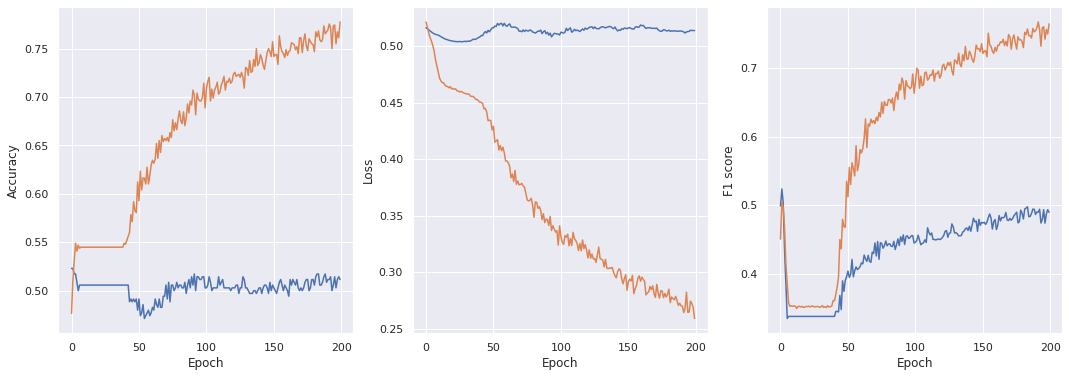

In [17]:
results_dji, _ = train_and_test('Processed_DJI', runs = 1)
#results_nasdaq, _ = train_and_test('Processed_NASDAQ', runs = 1)
#results_nyse, _ = train_and_test('Processed_NYSE', runs = 1)
#results_russell, _ = train_and_test('Processed_RUSSELL', runs = 1)
#results_sp, _ = train_and_test('Processed_SP', runs = 1)

In [ ]:
results_dji

In [ ]:
results_nasdaq

In [32]:
results_nyse

,MAE_mean,ACCURACY_mean,F1 Macro_mean,MAE_std,ACCURACY_std,F1 Macro_std
Test,0.490316,0.511391,0.474585,0.019501,0.021747,0.030209
Train,0.231389,0.795510,0.783026,0.039434,0.045037,0.051986
Val,0.505956,0.493966,0.434388,0.014543,0.017163,0.034036


In [30]:
results_russell

,MAE_mean,ACCURACY_mean,F1 Macro_mean,MAE_std,ACCURACY_std,F1 Macro_std
Test,0.478362,0.521598,0.505282,0.024092,0.029478,0.027861
Train,0.195102,0.834235,0.830241,0.019966,0.021334,0.023365
Val,0.497095,0.503736,0.479556,0.019520,0.024456,0.036765


In [31]:
results_sp

,MAE_mean,ACCURACY_mean,F1 Macro_mean,MAE_std,ACCURACY_std,F1 Macro_std
Test,0.468113,0.532544,0.462754,0.018968,0.020832,0.041802
Train,0.285679,0.732092,0.687056,0.067016,0.075527,0.119771
Val,0.512650,0.486063,0.412918,0.016217,0.020132,0.045657
